In [73]:

import os
from torch.utils.data import Dataset
import numpy as np
import cv2
import math
import pickle
from pathlib import Path

unipen_root = "../../data/handwriting/Unipen/train_r01_v07/include"

data_providers = os.listdir(unipen_root)

for data_provider in data_providers:
    print(f"Looking at provider {data_provider}")
    data_provider_path = os.path.join(unipen_root, data_provider)
    data_path = os.path.join(data_provider_path, "data")

    if not os.path.exists(data_path):
        print(f"Data provider {data_provider} without data")
        continue

    doc_files = [filename for filename in os.listdir(data_provider_path) if filename != "data"]
    print(f"Doc files: {doc_files}")
    print(f"Stroke files: {os.listdir(data_path)}")
    

Looking at provider abm
Doc files: ['abm0.doc']
Stroke files: ['ca0.dat', 'ibo0.dat', 'sm0.dat', 'wz0.dat']
Looking at provider aga
Doc files: []
Stroke files: ['amywldrp.dat', 'annzchrl.dat', 'crlmtchl.dat', 'dawnmrsh.dat', 'drdvlllb.dat', 'elsbthey.dat', 'greghunt.dat', 'jamesmor.dat', 'jhnshrly.dat', 'lzbthwht.dat', 'mlssdrry.dat', 'nikkshmn.dat', 'scttjyns.dat', 'shrncrtr.dat']
Looking at provider anj
Doc files: ['anj.doc', 'anj.lex']
Stroke files: ['g9303.dat', 'g9304.dat', 'g9312.dat', 'g9313.dat', 'g9314.dat', 'g9318.dat']
Looking at provider apa
Doc files: ['app.doc']
Stroke files: ['apa00', 'apa01', 'apa02', 'apa03', 'apa04', 'apa09', 'apa10', 'apa12', 'apa13', 'apa14', 'apa15', 'apa16', 'apa19', 'apa20']
Looking at provider apb
Doc files: ['app.doc']
Stroke files: ['apb02', 'apb04', 'apb05', 'apb06', 'apb07', 'apb08', 'apb09', 'apb10', 'apb12', 'apb13', 'apb14', 'apb15', 'apb16', 'apb17', 'apb18', 'apb20', 'apb21', 'apb22', 'apb23', 'apb24', 'apb25', 'apb27', 'apb28', 'apb29'

In [74]:
from enum import Enum
class UnipenKeywords(Enum):
    # Config-related
    X_DIM = "X_DIM"
    Y_DIM = "Y_DIM"
    X_POINTS_PER_INCH = "X_POINTS_PER_INCH"
    Y_POINTS_PER_INCH = "Y_POINTS_PER_INCH"
    X_POINTS_PER_MM = "X_POINTS_PER_MM"
    Y_POINTS_PER_MM = "Y_POINTS_PER_MM"

    POINTS_PER_SECOND = "POINTS_PER_SECOND"
    COORD = "COORD"

    # Stroke-related
    PEN_UP = "PEN_UP"
    PEN_DOWN = "PEN_DOWN"
    START_BOX = "START_BOX"

In [75]:
import re

class UnipenHandler():
    handler_root: str
    strokes: list[list[int, int, bool]]

    COMMAND_PATTERN = r"^\.(\w*) ?(.*)$"

    def __init__(self, handler_root: str):
        self.handler_root = handler_root
        self.strokes = []

    def process_doc(self):
        """Process the documentation of this Unipen handler, preparing helpers to decipher the stroke data files.
        The specific handler prepare its config there"""
        raise NotImplementedError

    def get_config_for_datafile(self, datafile: str) -> dict:
        """Get the configuration for the given data file. Specific to handler type."""
        raise NotImplementedError
    
    def search_values_in_file(self, filepath: str, search_keys: set[str], throw_on_missing: bool) -> dict:
        """Helper function.
        Search the given values inside of the file. Return every match in a dictionnary
        The function will either return empty values for missing keys, or throw an exception"""
        result_dict = {}
        found_keys = set()
        
        with open(filepath, "rt") as f:

            for line in f.readlines():
                command_match = re.match(UnipenHandler.COMMAND_PATTERN, line)
                if command_match:
                    if command_match.group(1) in search_keys:
                        key = command_match.group(1)
                        values = command_match.group(2).strip()
                        if " " in values:
                            values = values.split(" ")
                        found_keys.add(key)
                        try:
                            result_dict[key].extend(values)
                        except KeyError:
                            result_dict[key] = [*values]
        
        set_diff = search_keys-found_keys
        if len(set_diff) > 0:
            error = f"Missing key values {set_diff} on file {filepath}"
            if throw_on_missing:
                raise Exception(error)
            else:
                print(error)
        
        return result_dict

    def create_strokes(self): 
        """In single doc format, we can open the 'data' folder and expect files to be strokes / folder of files"""
        data_folder = os.path.join(self.handler_root, "data")
        self.scan_data_folder(data_folder)
    
    def scan_data_folder(self, data_folder: str):
        """Scan a data folder in search of stroke files. In case of nested folder, scan nested folders"""
        print(f"Scanning {data_folder}")
        for filename in os.listdir(data_folder):
            filepath = os.path.join(data_folder, filename)
            if os.path.isdir(filepath):
                self.scan_data_folder(filepath)
            elif os.path.isfile(filepath):
                print(f"File {filepath}")
                strokes = self.read_stroke_file(filepath)
                self.strokes.extend(strokes)

    def end_stroke(self, stroke: list):
        """End a stroke and register it"""
        if len(stroke) > 0:
            processed_stroke = self.process_stroke(np.array(stroke))
            self.strokes.append(processed_stroke)

    def read_stroke_file(self, filepath: str) -> list[tuple[int, int, bool]]:
        """Read a stroke file and return the list as a (x, y, penUp) signal"""
        configuration = self.get_config_for_datafile(filepath)
        coord_config: list = configuration[UnipenKeywords.COORD.value]

        idx, idy = coord_config.index("X"), coord_config.index("Y")

        #Read the line iteratively, line by line. Check if line is an instruction (.INSTRUCTION). If not, try to retrieve coordinates.
        strokes = []
        with open(filepath, "rt") as f:
            pen_down = False
            current_stroke = []
            for line in f:
                line = line.rstrip()

                #Gap
                if not line:
                    self.end_stroke(current_stroke)
                    current_stroke = []
                    continue

                command_match = re.match(UnipenHandler.COMMAND_PATTERN, line)
                if command_match:
                    match command_match.group(1):
                        #the penup signal is encoded in the last value of the stroke
                        case UnipenKeywords.PEN_UP.value:
                            pen_down = False
                            if len(current_stroke) > 0:
                                current_stroke[-1][2] = True
                        case UnipenKeywords.PEN_DOWN.value:
                            pen_down = True
                            #Well, some providers (anj) put a pen down WITHOUT a pen up, so we have to add the penup signal anyway.
                            if len(current_stroke) > 0:
                                current_stroke[-1][2] = True
                        case _:
                            continue
                else:
                    # Not empty line and not command: Assume coordinate line.
                    # Register points if and only if pen is down.
                    if not pen_down:
                        continue

                    coords = line.strip().split(" ")
                    x, y = int(coords[idx]), int(coords[idy])
                    if x==0 and y==0:
                        self.end_stroke(current_stroke)
                        current_stroke = []
                    else:
                        current_stroke.append([x, y, False])

        #Add last current stroke
        self.end_stroke(current_stroke)
        current_stroke = []

        return strokes
    
    def process_stroke(self, stroke: list[tuple[int, int, bool]]):
        """Apply post processing to the strokes"""
        align_strokes = True
        start_padding = 2

        #TODO
        # Frequency adjustment

        #TODO
        #Pix distance adjustment

        #Alignement / padding
        if align_strokes:
            min_x = min(stroke[:, 0])
            stroke[:, 0] -= (min_x - start_padding)

            min_y = min(stroke[:, 1])
            stroke[:, 1] -= (min_y - start_padding)

        return stroke


In [76]:
import re

class SingleDocFileHandler(UnipenHandler):
    """This handler manages Unipen provider with a single data file and a data/ folder containing strokes.
    If a or multiple lex file exist, ignore them"""

    config: dict
    
    def __init__(self, handler_root: str):
        super().__init__(handler_root)

        self.process_doc()

    def process_doc(self):
        """Process the documentation of this Unipen handler, preparing helpers to decipher the stroke data files"""
        #Retrieve single doc file
        files = os.listdir(self.handler_root)
        doc_candidates = [file for file in files if file.endswith(".doc")]
        if len(doc_candidates) != 1:
            raise Exception(f"Provider {self.handler_root}: Expected one doc file, found {doc_candidates}")

        doc_file = doc_candidates[0]

        #Parse doc file in order to find the data required to interpret the stroke
        required_search_values = set([UnipenKeywords.POINTS_PER_SECOND.value, UnipenKeywords.COORD.value])
        opt_search_values = set([
            UnipenKeywords.X_DIM.value, UnipenKeywords.Y_DIM.value,
            UnipenKeywords.X_POINTS_PER_INCH.value, UnipenKeywords.Y_POINTS_PER_INCH.value, 
            UnipenKeywords.X_POINTS_PER_MM.value, UnipenKeywords.Y_POINTS_PER_MM.value, 
        ])

        doc_filepath = os.path.join(self.handler_root, doc_file)
        self.config = {}
        self.config.update(self.search_values_in_file(doc_filepath, required_search_values, throw_on_missing=True))
        self.config.update(self.search_values_in_file(doc_filepath, opt_search_values, throw_on_missing=False))
        

    def get_config_for_datafile(self, datafile: str) -> dict:
        """Simple: In single doc mode the configuration is always the same"""
        return self.config

In [77]:
import os

class UnipenHandlerBuilder():
    """This class holds the knowledge of the UNIPEN data providers and their different formats.
    It can be used to build the different online signals through builders adapted to providers."""
    unipen_root: str

    provider_type_mapping = {
        SingleDocFileHandler: ["abm", "anj", "apa"],
    }

    def __init__(self, unipen_root: str) -> None:
        self.unipen_root = unipen_root

    def build_handlers(self) -> list[UnipenHandler]:
        """Build all the handlers declared by this provider maping"""
        provider_return: list[UnipenHandler] = []
        
        for handler_class, providers in self.provider_type_mapping.items():
            print(f"Len of providers: {len(providers)}")
            for provider in providers:
                try:
                    print(f"Building provider {provider} as {handler_class.__name__}")
                    print(type(provider))
                    provider_path = os.path.join(self.unipen_root, provider)
                    provider_handler = handler_class(provider_path)
                    provider_return.append(provider_handler)
                except Exception as e:
                    print(f"Impossible to build provider {provider} due to error: {e}")
                    raise e

        return provider_return

In [78]:
unipen_root = "../../data/handwriting/Unipen/train_r01_v07/include"

unipen_handler_builder = UnipenHandlerBuilder(unipen_root)
handlers = unipen_handler_builder.build_handlers()

print(f"built {len(handlers)} handlers")

Len of providers: 3
Building provider abm as SingleDocFileHandler
<class 'str'>
Missing key values {'Y_POINTS_PER_MM', 'X_POINTS_PER_MM'} on file ../../data/handwriting/Unipen/train_r01_v07/include/abm/abm0.doc
Building provider anj as SingleDocFileHandler
<class 'str'>
Missing key values {'Y_POINTS_PER_INCH', 'X_POINTS_PER_INCH'} on file ../../data/handwriting/Unipen/train_r01_v07/include/anj/anj.doc
Building provider apa as SingleDocFileHandler
<class 'str'>
Missing key values {'Y_POINTS_PER_MM', 'X_POINTS_PER_MM'} on file ../../data/handwriting/Unipen/train_r01_v07/include/apa/app.doc
built 3 handlers


In [79]:
for handler in handlers:
    handler.create_strokes()
    print(f"strokes: {len(handler.strokes)}")

strokes: 653
strokes: 709


ValueError: invalid literal for int() with base 10: '209\t434'

In [ ]:
import numpy as np

DRAW_COLOR_BLACK = 255
DRAW_COLOR_WHITE = 0

def create_image(signal: list[int, int, bool], draw_color = 1):
    """Create the image associated with the given signal."""
    max_h =  int(math.ceil(max(signal[:, 0])))
    max_w = int(math.ceil(max(signal[:, 1])))

    canvas = np.ascontiguousarray(np.full((max_w + 2, max_h + 2), DRAW_COLOR_BLACK), dtype=np.uint8)
    print(f"Canvas: {canvas.shape}")
    
    #Draw lines from point (t-1) to current point (t) IFF the pen was not up. start with penup
    #as we start from point 0.
    draw_current_stroke = False
    for x, y, eos in signal:
        if draw_current_stroke:
            cv2.line(canvas, (last_x, last_y), (x, y), DRAW_COLOR_WHITE, draw_color) 
        last_x, last_y, draw_current_stroke = x, y, not eos
    
    return canvas

(402, 3)
Canvas: (51, 217)


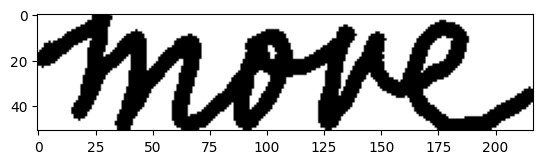

(298, 3)
Canvas: (66, 214)


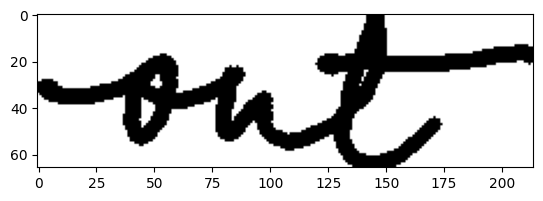

(285, 3)
Canvas: (70, 198)


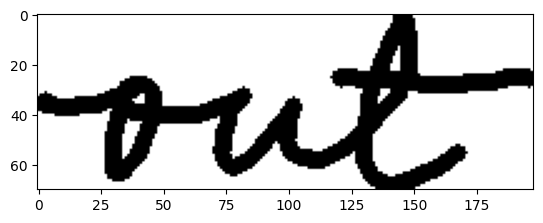

(256, 3)
Canvas: (69, 195)


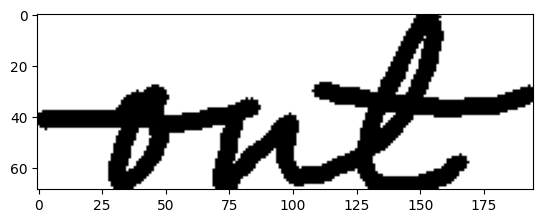

(576, 3)
Canvas: (78, 428)


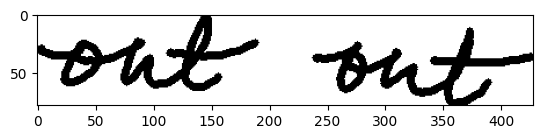

In [ ]:
import matplotlib.pyplot as plt
from random import randint

handler = handlers[2]

strokes = handler.strokes

n = randint(0, len(strokes) - 6)

for stroke in strokes[n:n+5]:
    print(stroke.shape)

    max_y = max(stroke[:, 1])
    stroke[:, 1] = max_y - stroke[:, 1]
    
    image = create_image(stroke, 5)

    plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.show()